<a href="https://colab.research.google.com/github/tugolukov/cats-vs-dogs/blob/main/cats-vs-dogs-image-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Настройка рабочего окружения

*   Монтирование дискового пространства на Google Drive
*   Импорт используемых библиотек
*   Объявление переменных
*   Объявление вспомогательных функций



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import io
import os
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras import backend as K

In [ ]:
work_dir = "/content/drive/MyDrive/kaggle/working/PetImages/"
work_dataset = tf.keras.preprocessing.image_dataset_from_directory(work_dir)
batch_size = 32
img_height = 180
img_width = 180
isFilter = False

Found 23439 files belonging to 2 classes.


In [ ]:
def getName(index):
    if index == 0:
        return "Cat"
    else:
        return "Dog"

In [ ]:
def filter(dir):
  num_skipped = 0
  for folder_name in ("Cat", "Dog"):
      folder_path = os.path.join(dir, folder_name)
      for fname in os.listdir(folder_path):
          fpath = os.path.join(folder_path, fname)
          try:
              fobj = open(fpath, "rb")
              is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
          finally:
              fobj.close()
          if not is_jfif:
              num_skipped += 1
              os.remove(fpath)
  print("Удалено %d изображений" % num_skipped)

# Предварительное исследование данных

Подготовка к созданию и обучению модели



In [ ]:
# Вывод наименований директорий
!ls "/content/drive/MyDrive/kaggle/working/PetImages/"

# Отображение классов для классификации
work_dataset.class_names

Cat  Dog


['Cat', 'Dog']

In [ ]:
# Проверка изображений и меток
for image_batch, labels_batch in work_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


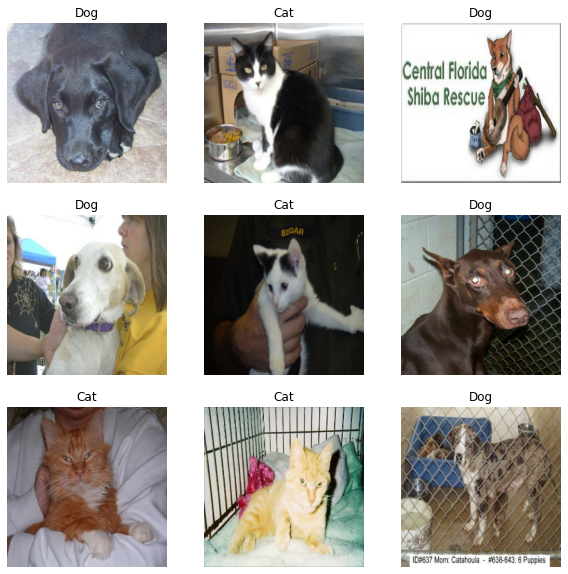

In [ ]:
# Отображение образцов изображений с метками
plt.figure(figsize=(10, 10))
for images, labels in work_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(getName(int(labels[i])))
        plt.axis("off")

# Фильтрация поврежденных изображений

In [ ]:
# Фильтрация поврежденных изображений
if isFilter:
    filter(work_dir)

# Установка тренировочного и тестового наборов данных

In [ ]:
# Установка тренировочного и тестового наборов данных
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    work_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    work_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 23439 files belonging to 2 classes.
Using 18752 files for training.
Found 23439 files belonging to 2 classes.
Using 4687 files for validation.


# Анализ данных

In [ ]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)])

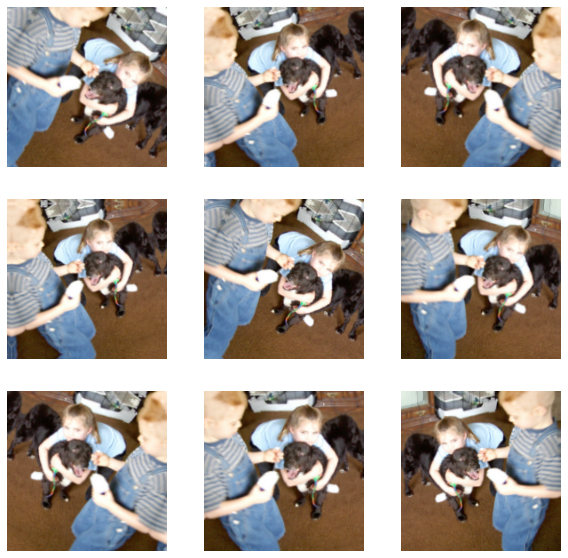

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Моделирование данных

In [ ]:
# Проверка каналов изображений
if K.image_data_format() == "channels_first":
    input_shape = (3, img_height, img_width)
else:
    input_shape = (img_height, img_width, 3)

# Создание модели обучения

In [ ]:
# Создание модели обучения
model_dl = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape)),
  layers.Conv2D(16, 3, padding="same", activation="relu"),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding="same", activation="relu"),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding="same", activation="relu"),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])

# Обучение и оценка алгоритма

In [ ]:
# Сборка нейронной сети
model_dl.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])
model_dl.fit(train_dataset, validation_data=test_dataset, epochs=5)
model_dl.save("model_dl.h5")

Epoch 1/5
586/586 [==============================] - 5796s 10s/step - loss: 0.6672 - accuracy: 0.6013 - val_loss: 0.5653 - val_accuracy: 0.7214
Epoch 2/5
586/586 [==============================] - 728s 1s/step - loss: 0.5633 - accuracy: 0.7090 - val_loss: 0.5056 - val_accuracy: 0.7529
Epoch 3/5
586/586 [==============================] - 724s 1s/step - loss: 0.5189 - accuracy: 0.7449 - val_loss: 0.4829 - val_accuracy: 0.7719
Epoch 4/5
586/586 [==============================] - 728s 1s/step - loss: 0.4910 - accuracy: 0.7623 - val_loss: 0.4596 - val_accuracy: 0.7826
Epoch 5/5
586/586 [==============================] - 729s 1s/step - loss: 0.4657 - accuracy: 0.7713 - val_loss: 0.4427 - val_accuracy: 0.7954


# Развертывание модели

16384/15358 [================================] - 0s 0us/step


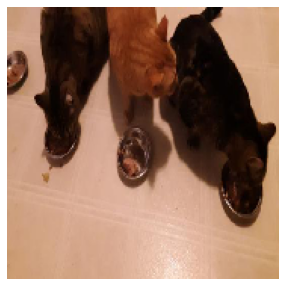

Это изображение относится к классу Cat с вероятностью 59.22 процентов


In [ ]:
# Использование рандомного изображения кота из интернета
model_dl = keras.models.load_model("model_dl.h5")

picture_url = "https://cataas.com/cat?height=300"
picture_path = tf.keras.utils.get_file("cat", origin=picture_url)

img = keras.preprocessing.image.load_img(picture_path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model_dl.predict(img_array)
score = tf.nn.sigmoid(predictions[0])

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis("off")
plt.show()

print("Это изображение относится к классу {} с вероятностью {:.2f} процентов".format(work_dataset.class_names[np.argmax(score)], 100 * np.max(score)))